In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tarunparuchur/98-accuracy-for-satellite-image-classification --unzip

## Import Dependencies

In [ ]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Load the Data

In [ ]:
data_dir = 'satellite-image-classification/data'

In [ ]:
categories  = ['cloudy', 'desert', 'green_area', 'water']
data = []
data_labels = []

for categorie in categories :
    folder_path = os.path.join(data_dir, categorie)
    image_paths = os.listdir(folder_path)
    data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])
    data_labels.extend([categorie] * len(image_paths))
data = pd.DataFrame({'Image_Path' : data, 'labels' : data_labels})
data

,Image_Path,labels
0,/kaggle/input/satellite-image-classification/d...,cloudy
1,/kaggle/input/satellite-image-classification/d...,cloudy
2,/kaggle/input/satellite-image-classification/d...,cloudy
3,/kaggle/input/satellite-image-classification/d...,cloudy
4,/kaggle/input/satellite-image-classification/d...,cloudy
...,...,...
5626,/kaggle/input/satellite-image-classification/d...,water
5627,/kaggle/input/satellite-image-classification/d...,water
5628,/kaggle/input/satellite-image-classification/d...,water
5629,/kaggle/input/satellite-image-classification/d...,water


## Data Visualization

Displaying Some Sample images of 'cloudy' categorie : 


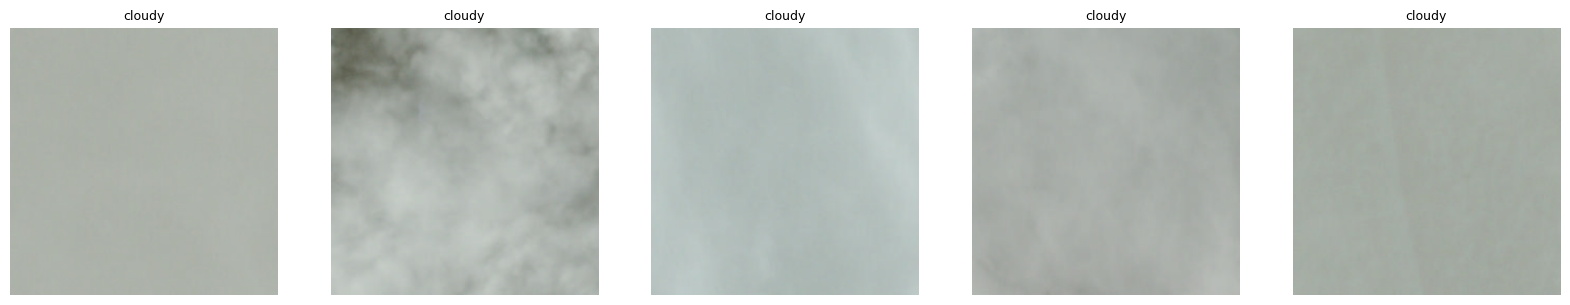

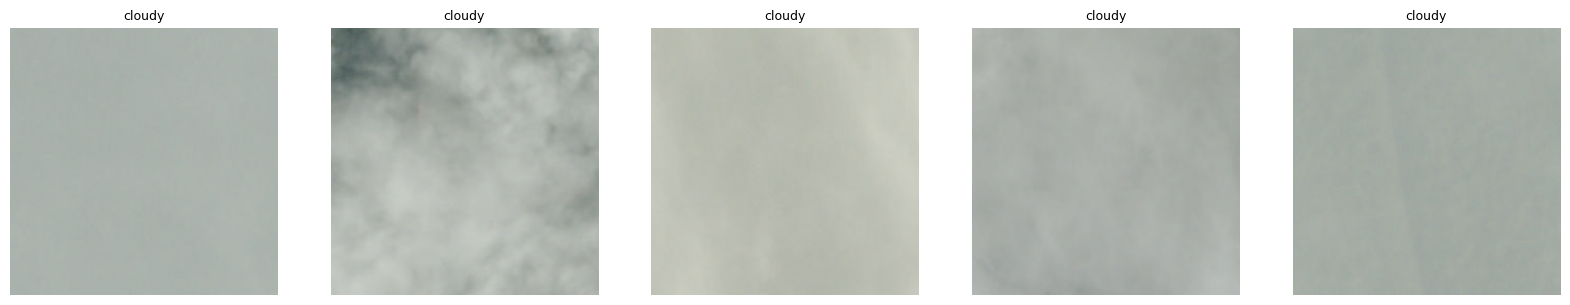

Displaying Some Sample images of 'desert' categorie : 


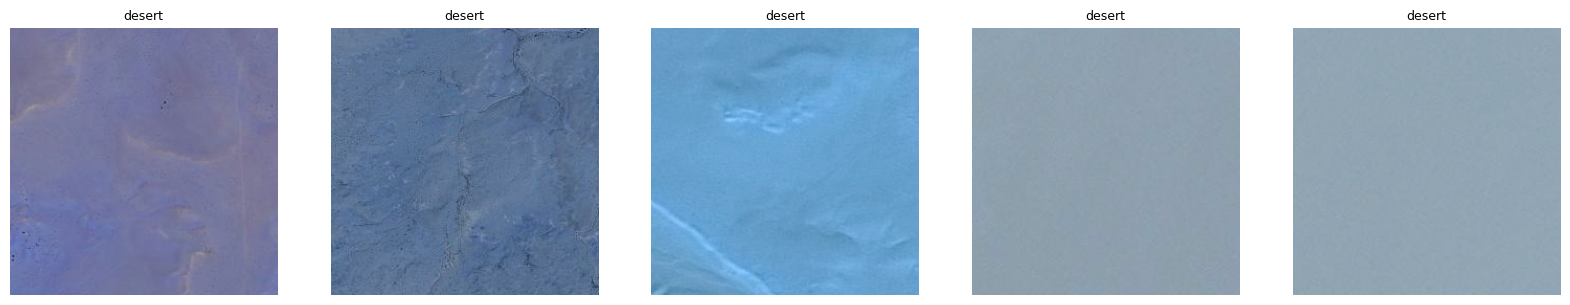

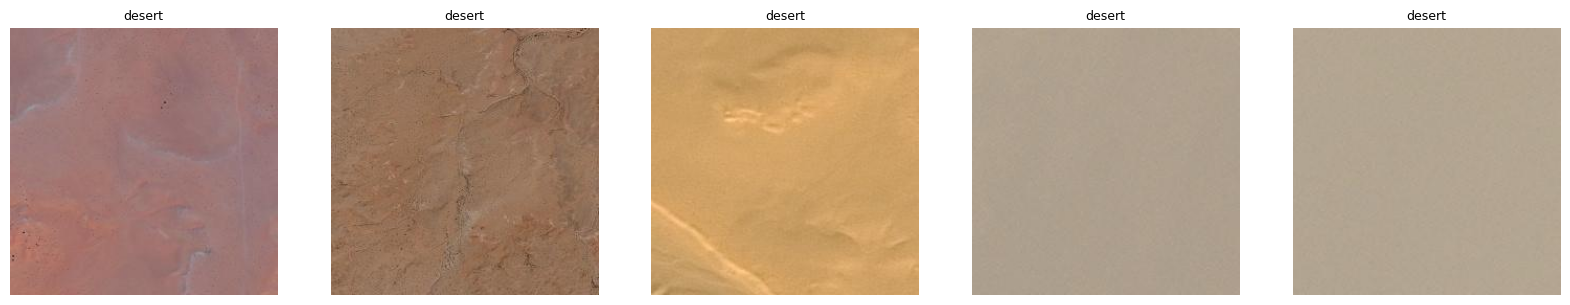

Displaying Some Sample images of 'green_area' categorie : 


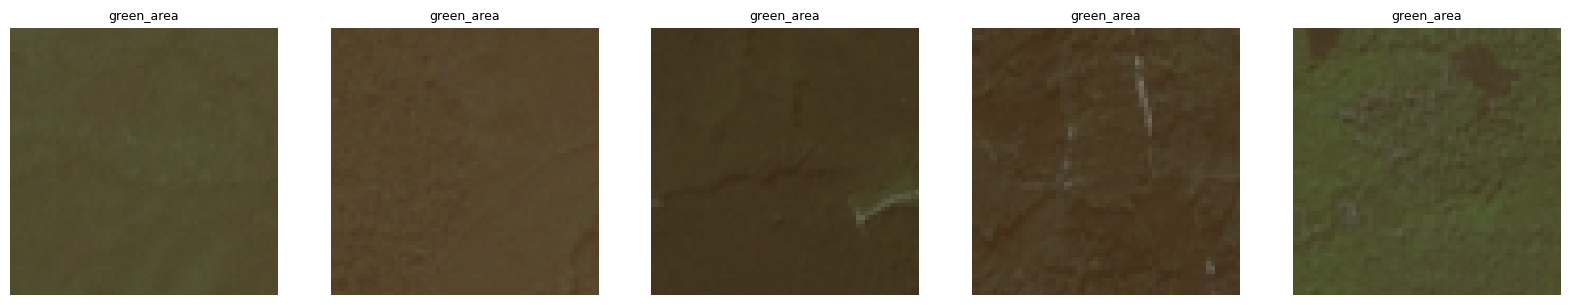

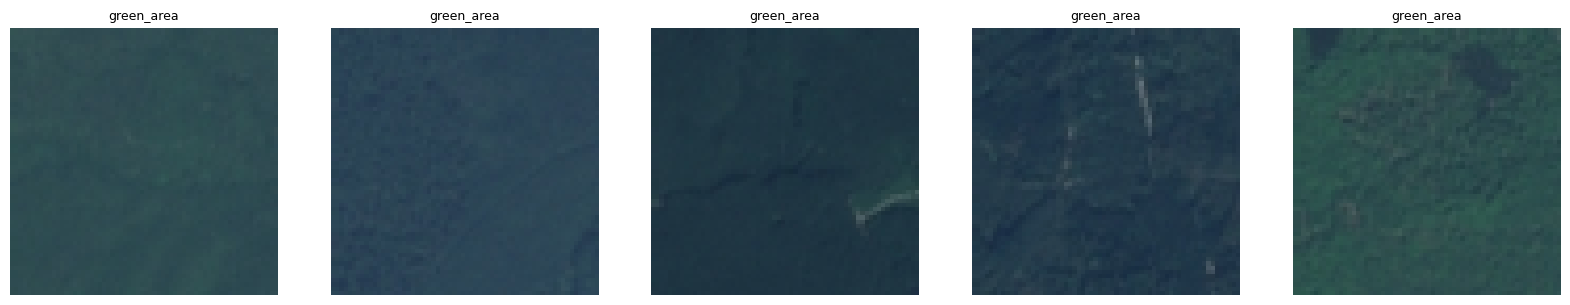

Displaying Some Sample images of 'water' categorie : 


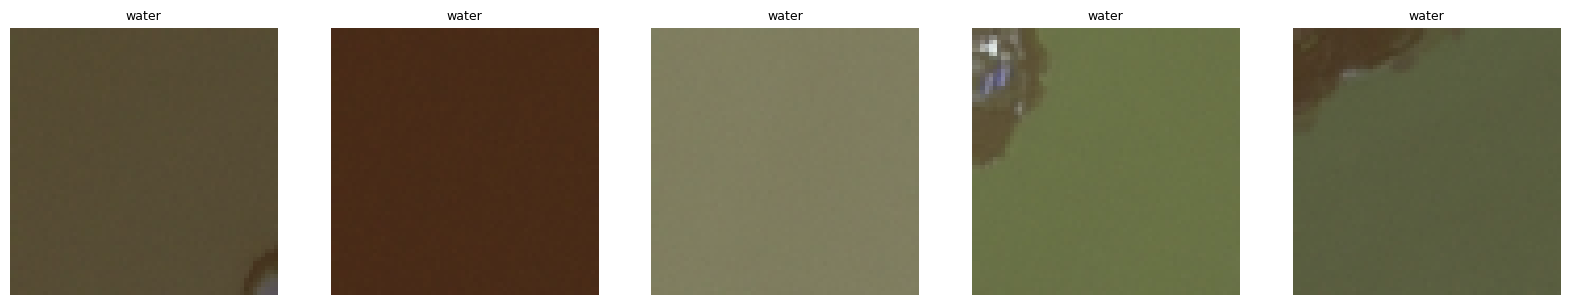

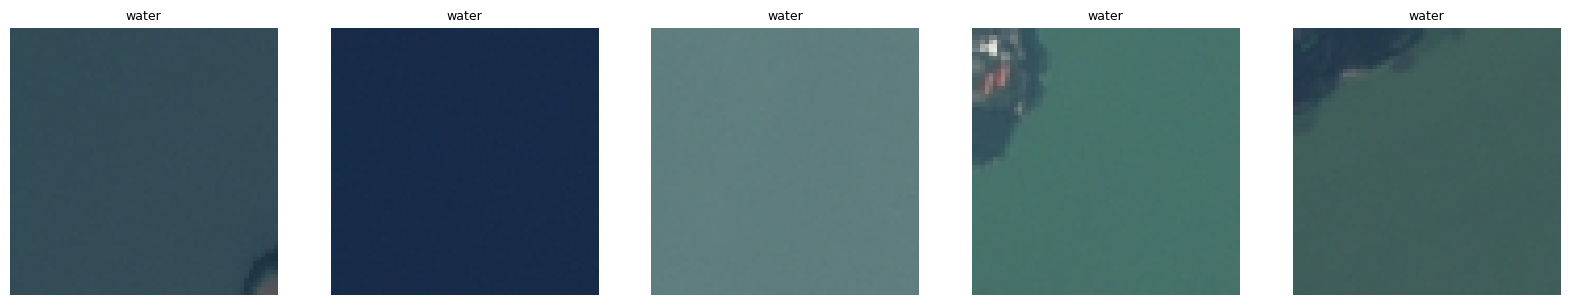

In [ ]:
labels = ['cloudy', 'desert', 'green_area', 'water']

for label in labels:
    sample_images = data[data['labels'] == label]['Image_Path'].reset_index(drop=True)[:5]

    print(f"Displaying Some Sample images of '{label}' categorie : ")
    plt.figure(figsize=(20, 8))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        img = cv2.imread(sample_images[i])
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')
    plt.show()
    plt.figure(figsize=(20, 8))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1 + 5)
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')

    plt.show()

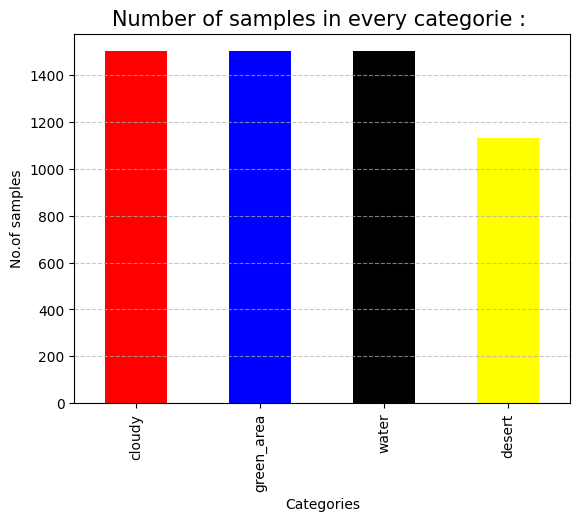

In [ ]:
data['labels'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'black', 'yellow'])
plt.title('Number of samples in every categorie : ', fontsize = 15)
plt.xlabel('Categories')
plt.ylabel('No.of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

## Data Generator

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.25,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    zoom_range = 0.2
)


In [ ]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=10,
    class_mode='categorical',
    shuffle=True
)

Found 4224 images belonging to 4 classes.
Found 1407 images belonging to 4 classes.
Found 5631 images belonging to 4 classes.


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

## Model Building

### VGG

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model1 = Model(inputs = vgg_model.input, outputs=predictions)

### Inception Resnet

In [ ]:
InceptionResNetV2_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(75, 75, 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in InceptionResNetV2_model.layers:
    layer.trainable = False

x = InceptionResNetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model2 = Model(inputs = InceptionResNetV2_model.input, outputs=predictions)

### Xception

In [ ]:
Xception_model = Xception(include_top=False, weights="imagenet", input_shape=(75,75,3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in Xception_model.layers:
    layer.trainable = False

x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model3 = Model(inputs = Xception_model.input, outputs=predictions)

### Resnet


In [ ]:
ResNet50V2_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(75,75,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in ResNet50V2_model.layers:
    layer.trainable = False

x = ResNet50V2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model4 = Model(inputs = ResNet50V2_model.input, outputs=predictions)

## Compiling Models

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [ ]:
mc1 = ModelCheckpoint('best_VGG16_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weights,
    callbacks=[es, mc1, lrd]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 337ms/step - accuracy: 0.5021 - loss: 1.1233 - val_accuracy: 0.8017 - val_loss: 0.5369 - learning_rate: 0.0010
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.8517 - loss: 0.4878 - val_accuracy: 0.8173 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.8814 - loss: 0.3642 - val_accuracy: 0.8991 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.8923 - loss: 0.3070 - val_accuracy: 0.8628 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9073 - loss: 0.2802 - val_accuracy: 0.8380 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.8994 - loss: 0.2793 - val_accuracy: 0.9076 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9241 - loss:

In [ ]:
mc2 = ModelCheckpoint('best_InceptionResNetV2_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weights,
    callbacks=[es, mc2, lrd]
)

Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 74s 374ms/step - accuracy: 0.4518 - loss: 4.2087 - val_accuracy: 0.5345 - val_loss: 1.5618 - learning_rate: 0.0010
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 294ms/step - accuracy: 0.5193 - loss: 1.4567 - val_accuracy: 0.5473 - val_loss: 1.5509 - learning_rate: 0.0010
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.5314 - loss: 1.5168 - val_accuracy: 0.5480 - val_loss: 1.9077 - learning_rate: 0.0010
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 285ms/step - accuracy: 0.5146 - loss: 1.5782 - val_accuracy: 0.5778 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - accuracy: 0.5254 - loss: 1.4089 - val_accuracy: 0.5707 - val_loss: 1.1766 - learning_rate: 0.0010
Epoch 5: early stopping


In [ ]:
mc3 = ModelCheckpoint('best_Xception_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, mc3, lrd]
)

Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.5773 - loss: 1.1390 - val_accuracy: 0.6660 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6704 - loss: 0.8208 - val_accuracy: 0.7107 - val_loss: 0.7474 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.7343 - loss: 0.6994 - val_accuracy: 0.7889 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.7836 - loss: 0.6079 - val_accuracy: 0.8081 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.8090 - loss: 0.5735 - val_accuracy: 0.8209 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 5: early stopping


In [ ]:
mc4 = ModelCheckpoint('best_ResNet50V2_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model4.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, mc4, lrd]
)

Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.8519 - loss: 0.3866 - val_accuracy: 0.9609 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.9562 - loss: 0.1353 - val_accuracy: 0.9552 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.9563 - loss: 0.1307 - val_accuracy: 0.9538 - val_loss: 0.1314 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.9581 - loss: 0.1135 - val_accuracy: 0.9538 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.9647 - loss: 0.0891 - val_accuracy: 0.9659 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.9705 - loss: 0.0905 - val_accuracy: 0.9687 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.9

## Evaluation on Validation Dataset

In [ ]:
val_loss, val_accuracy = model1.evaluate(val_data)
print(f"Model1 Validation Loss: {val_loss}")
print(f"Model1 Validation Accuracy: {val_accuracy}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8598 - loss: 0.3871
Model1 Validation Loss: 0.23826010525226593
Model1 Validation Accuracy: 0.9125799536705017


In [ ]:
val_loss, val_accuracy = model2.evaluate(val_data)
print(f"Model2 Validation Loss: {val_loss}")
print(f"Model2 Validation Accuracy: {val_accuracy}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.4001 - loss: 1.6042
Model2 Validation Loss: 1.1448619365692139
Model2 Validation Accuracy: 0.5700070858001709


In [ ]:
val_loss, val_accuracy = model3.evaluate(val_data)
print(f"Model3 Validation Loss: {val_loss}")
print(f"Model3 Validation Accuracy: {val_accuracy}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7804 - loss: 0.6013
Model3 Validation Loss: 0.5151143670082092
Model3 Validation Accuracy: 0.8201847672462463


In [ ]:
val_loss, val_accuracy = model4.evaluate(val_data)
print(f"Model4 Validation Loss: {val_loss}")
print(f"Model4 Validation Accuracy: {val_accuracy}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9802 - loss: 0.0667
Model4 Validation Loss: 0.08450885117053986
Model4 Validation Accuracy: 0.9744136333465576


**We achieved the highest accuracy with the ResNet50V2 model, so we are taking that model's history and observing its graphs.**

## Model Evaluation

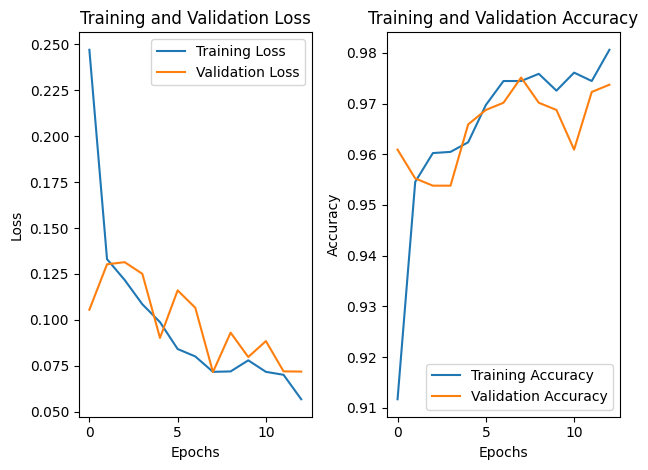

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class_names = list(val_data.class_indices.keys())

val_predictions = model4.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)
y_true = val_data.classes

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


### Classification Report

In [ ]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


Test Classification Report:
              precision    recall  f1-score   support

      cloudy       0.98      0.98      0.98       375
      desert       0.98      0.99      0.98       282
  green_area       0.96      0.99      0.98       375
       water       0.99      0.95      0.97       375

    accuracy                           0.98      1407
   macro avg       0.98      0.98      0.98      1407
weighted avg       0.98      0.98      0.98      1407



### Confusion Matrix


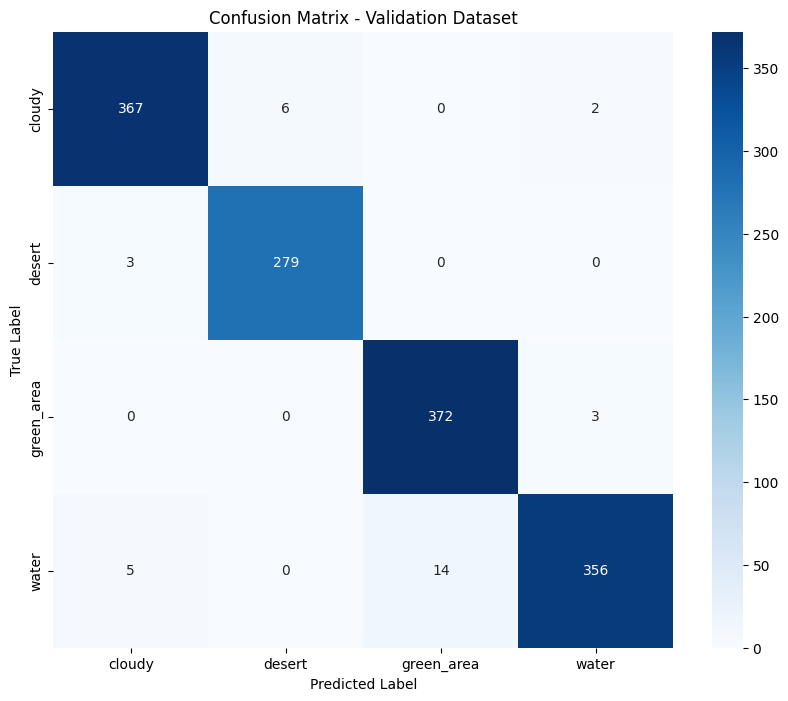

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Output Prediction and Probabilities test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


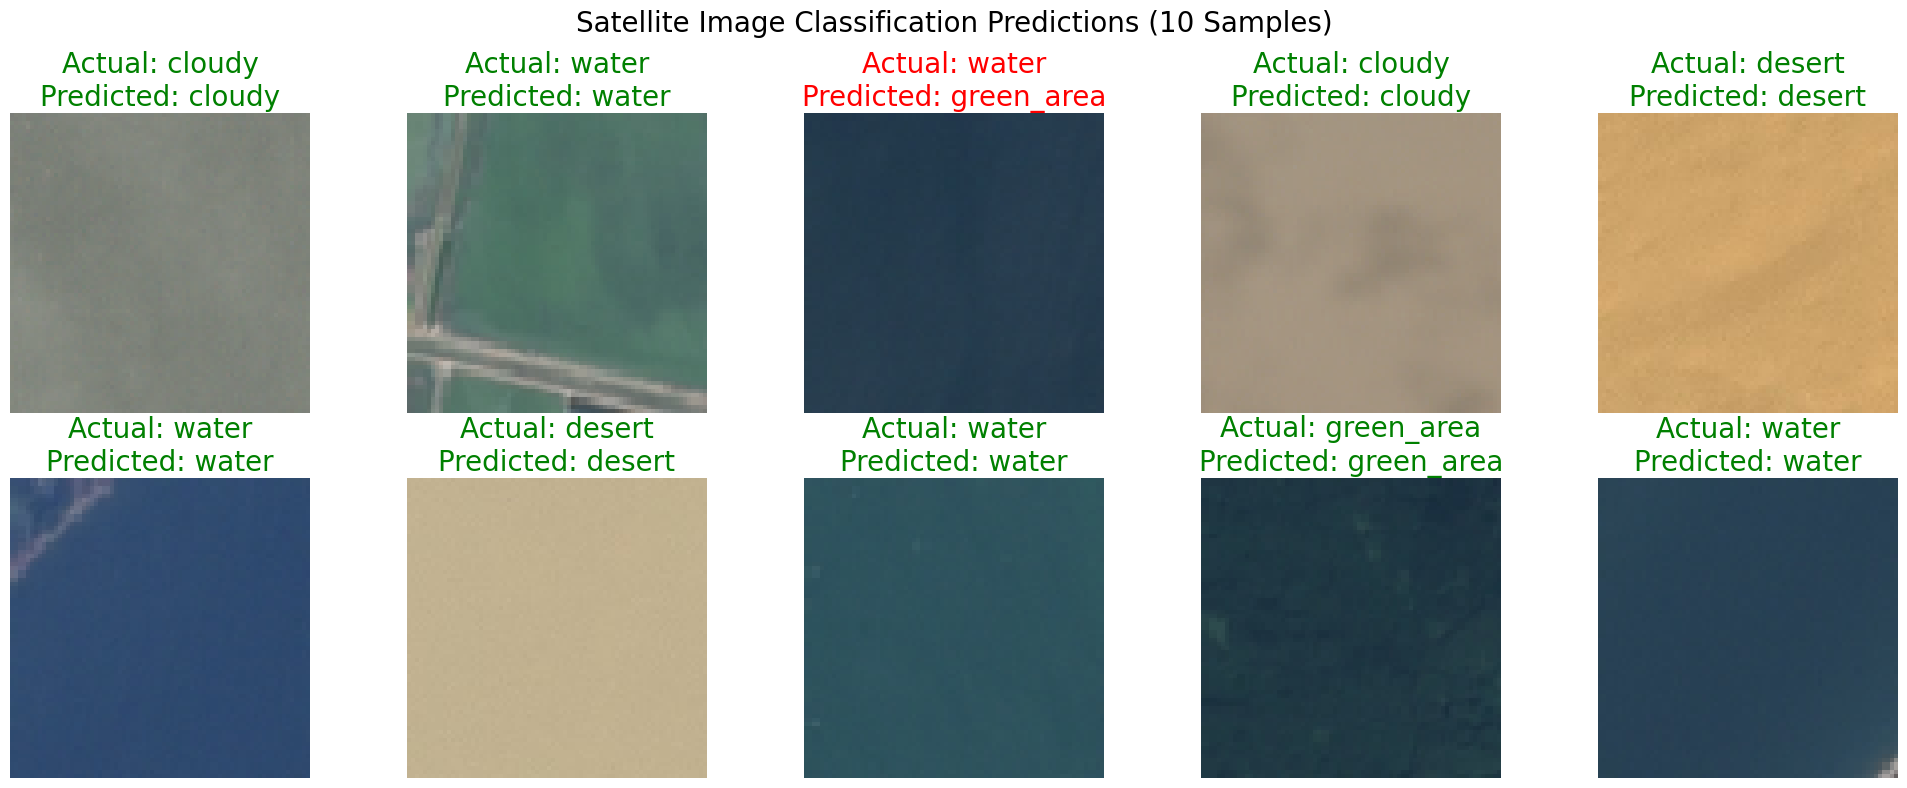

In [ ]:
class_names = list(test_data.class_indices.keys())

num_rows = int(np.ceil(10 / 5))

plt.figure(figsize=(20, 8))

test_images, test_labels = next(test_data)
test_images = test_images[:10]
test_labels = test_labels[:10]

for i in range(10):
    img = test_images[i]
    true_class = np.argmax(test_labels[i])
    predicted_class = np.argmax(model4.predict(np.expand_dims(img, axis=0)), axis=-1)
    is_correct = true_class == predicted_class[0]
    title_color = 'green' if is_correct else 'red'
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[predicted_class[0]]}", fontsize = 20, color=title_color)
    plt.axis('off')

plt.suptitle('Satellite Image Classification Predictions (10 Samples)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
